# All imports necessary

In [56]:
import pandas as pd 
import datetime as dt
import numpy as np
import sklearn
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings

from scipy import stats
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pandas import concat
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [2]:
import os
import re
import sys
import zipfile
from collections import UserDict

import requests

pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

## Helpful functions

In [91]:
def download_file(url):
    local_filename = re.search("^[^?]+", url.split("/")[-1]).group()
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename


def load_data(data_dir):
    """Load the GEFCom 2014 energy load data"""

    energy = pd.read_csv(
        os.path.join(data_dir, "energy.csv"), parse_dates=["timestamp"]
    )

    # Reindex the dataframe such that the dataframe has a record for every time point
    # between the minimum and maximum timestamp in the time series. This helps to
    # identify missing time periods in the data (there are none in this dataset).

    energy.index = energy["timestamp"]
    energy = energy.reindex(
        pd.date_range(min(energy["timestamp"]), max(energy["timestamp"]), freq="H")
    )
    energy = energy.drop("timestamp", axis=1)

    return energy

def extract_data(data_dir):
    GEFCom_dir = os.path.join(data_dir, "GEFCom2014", "GEFCom2014 Data")

    GEFCom_zipfile = os.path.join(data_dir, "GEFCom2014.zip")
    if not os.path.exists(GEFCom_zipfile):
        sys.exit(
            "Download GEFCom2014.zip from https://mlftsfwp.blob.core.windows.net/mlftsfwp/GEFCom2014.zip and save it to the '{}' directory.".format(
                data_dir
            )
        )

    # unzip root directory
    zip_ref = zipfile.ZipFile(GEFCom_zipfile, "r")
    zip_ref.extractall(os.path.join(data_dir, "GEFCom2014"))
    zip_ref.close()

    # extract the extended competition data
    zip_ref = zipfile.ZipFile(os.path.join(GEFCom_dir, "GEFCom2014-E_V2.zip"), "r")
    zip_ref.extractall(os.path.join(data_dir, "GEFCom2014-E"))
    zip_ref.close()

    # load the data from Excel file
    data = pd.read_excel(
        os.path.join(data_dir, "GEFCom2014-E", "GEFCom2014-E.xlsx"), parse_dates=["Date"]
    )

    # create timestamp variable from Date and Hour
    data["timestamp"] = data["Date"].add(pd.to_timedelta(data.Hour - 1, unit="h"))
    data = data[["timestamp", "load", "T"]]
    data = data.rename(columns={"T": "temp"})

    # remove time period with no load data
    data = data[data.timestamp >= "2012-01-01"]

    # save to csv
    data.to_csv(os.path.join(data_dir, "energy.csv"), index=False)

In [89]:
class TimeSeriesTensor(UserDict):
    """A dictionary of tensors for input into the RNN model.
     This class is used to:
      1. Shift the values of the time series to create a Pandas dataframe containing all the data
         for a single training example
      2. Discard any samples with missing values
      3. Transform this Pandas dataframe into a numpy array of shape
         (samples, time steps, features) for input into Keras
    The class takes the following parameters:
       - **dataset**: original time series
       - **target** name of the target column
       - **H**: the forecast horizon
       - **tensor_structures**: a dictionary discribing the tensor structure of the form
             { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
             if features are non-sequential and should not be shifted, use the form
             { 'tensor_name' : (None, [feature, feature, ...])}
       - **freq**: time series frequency (default 'H' - hourly)
       - **drop_incomplete**: (Boolean) whether to drop incomplete samples (default True)
    """

    def __init__(
        self, dataset, target, H, tensor_structure, freq="H", drop_incomplete=True
    ):
        self.dataset = dataset
        self.target = target
        self.tensor_structure = tensor_structure
        self.tensor_names = list(tensor_structure.keys())

        self.dataframe = self._shift_data(H, freq, drop_incomplete)
        self.data = self._df2tensors(self.dataframe)

    def _shift_data(self, H, freq, drop_incomplete):

        # The tensor_structures definitions are used to shift the features in the original dataset.
        # The result is a Pandas dataframe with multi-index columns in the hierarchy
        #     tensor - the name of the input tensor
        #     feature - the input feature to be shifted
        #     time step - the time step for the RNN in which the data is input. These labels
        #         are centred on time t. the forecast creation time
        df = self.dataset.copy()

        idx_tuples = []
        for t in range(1, H + 1):
            df["t+" + str(t)] = df[self.target].shift(t * -1, freq=freq)
            idx_tuples.append(("target", "y", "t+" + str(t)))

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            dataset_cols = structure[1]

            for col in dataset_cols:

                # do not shift non-sequential 'static' features
                if rng is None:
                    df["context_" + col] = df[col]
                    idx_tuples.append((name, col, "static"))

                else:
                    for t in rng:
                        sign = "+" if t > 0 else ""
                        shift = str(t) if t != 0 else ""
                        period = "t" + sign + shift
                        shifted_col = name + "_" + col + "_" + period
                        df[shifted_col] = df[col].shift(t * -1, freq=freq)
                        idx_tuples.append((name, col, period))

        df = df.drop(self.dataset.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(
            idx_tuples, names=["tensor", "feature", "time step"]
        )
        df.columns = idx

        if drop_incomplete:
            df = df.dropna(how="any")

        return df

    def _df2tensors(self, dataframe):

        # Transform the shifted Pandas dataframe into the multidimensional numpy arrays. These
        # arrays can be used to input into the keras model and can be accessed by tensor name.
        # For example, for a TimeSeriesTensor object named "model_inputs" and a tensor named
        # "target", the input tensor can be acccessed with model_inputs['target']

        inputs = {}
        y = dataframe["target"]
        y = y.to_numpy()
        inputs["target"] = y

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            cols = structure[1]
            tensor = dataframe[name][cols].to_numpy()
            if rng is None:
                tensor = tensor.reshape(tensor.shape[0], len(cols))
            else:
                tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
                tensor = np.transpose(tensor, axes=[0, 2, 1])
            inputs[name] = tensor

        return inputs

    def subset_data(self, new_dataframe):

        # This function is used to recreate the input tensors if the shifted dataframe
        # has been filtered.

        self.dataframe = new_dataframe
        self.data = self._df2tensors(self.dataframe)

In [90]:
def create_evaluation_df(predictions, test_inputs, H, scaler):
    """Create a data frame for easy evaluation"""
    eval_df = pd.DataFrame(
        predictions, columns=["t+" + str(t) for t in range(1, H + 1)]
    )
    eval_df["timestamp"] = test_inputs.dataframe.index
    eval_df = pd.melt(
        eval_df, id_vars="timestamp", value_name="prediction", var_name="h"
    )
    eval_df["actual"] = np.transpose(test_inputs["target"]).ravel()
    eval_df[["prediction", "actual"]] = scaler.inverse_transform(
        eval_df[["prediction", "actual"]]
    )
    return eval_df

## Dowloading data

In [4]:
data_dir = "./data"

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

if not os.path.exists(os.path.join(data_dir, "energy.csv")):
    download_file("https://mlftsfwp.blob.core.windows.net/mlftsfwp/GEFCom2014.zip")
    shutil.move("GEFCom2014.zip", os.path.join(data_dir, "GEFCom2014.zip"))
    extract_data(data_dir)

In [11]:
ts_data = load_data(data_dir)
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [9]:
ts_data_load.index

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2014-12-31 14:00:00', '2014-12-31 15:00:00',
               '2014-12-31 16:00:00', '2014-12-31 17:00:00',
               '2014-12-31 18:00:00', '2014-12-31 19:00:00',
               '2014-12-31 20:00:00', '2014-12-31 21:00:00',
               '2014-12-31 22:00:00', '2014-12-31 23:00:00'],
              dtype='datetime64[ns]', length=26304, freq='H')

In [12]:
ts_data.isna().sum()

load    0
temp    0
dtype: int64

In [13]:
ts_data.dtypes

load    float64
temp    float64
dtype: object

In [14]:
ts_data.describe()

,load,temp
count,"26,304.00","26,304.00"
mean,"3,303.77",47.77
std,564.58,19.34
min,"1,979.00",-13.67
25%,"2,867.00",32.67
50%,"3,364.00",48.33
75%,"3,690.00",63.67
max,"5,224.00",95.00


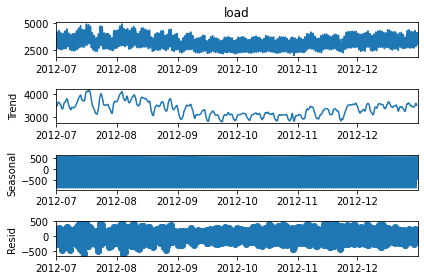

In [15]:
ts_data_load = ts_data["load"]
decomposition = sm.tsa.seasonal_decompose(
    ts_data_load["2012-07-01":"2012-12-31"], model="additive"
)

fig = decomposition.plot()
matplotlib.rcParams["figure.figsize"] = [10.0, 6.0]

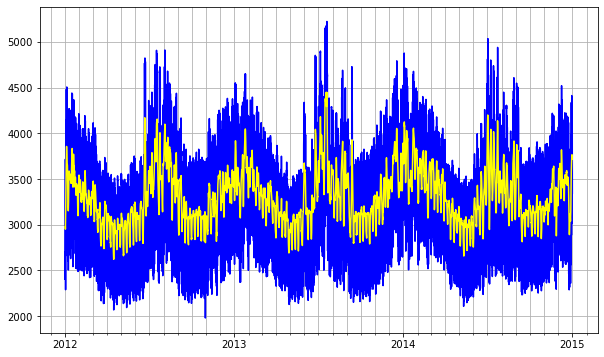

In [16]:
decomposition = sm.tsa.seasonal_decompose(ts_data_load, model="additive")

fig, ax = plt.subplots()
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=1)

year_format = mdates.DateFormatter("%Y")
month_format = mdates.DateFormatter("%m")

ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which="minor")
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

plt.plot(ts_data_load.index, ts_data_load, c="blue")
plt.plot(decomposition.trend.index, decomposition.trend, c="yellow")

## Data Cleaning

In [17]:
ts_data_load.interpolate(limit=8, method="linear", limit_direction="both")

2012-01-01 00:00:00   2,698.00
2012-01-01 01:00:00   2,558.00
2012-01-01 02:00:00   2,444.00
2012-01-01 03:00:00   2,402.00
2012-01-01 04:00:00   2,403.00
                        ...   
2014-12-31 19:00:00   4,012.00
2014-12-31 20:00:00   3,856.00
2014-12-31 21:00:00   3,671.00
2014-12-31 22:00:00   3,499.00
2014-12-31 23:00:00   3,345.00
Freq: H, Name: load, Length: 26304, dtype: float64

In [18]:
temp_mode = np.asscalar(stats.mode(ts_data["temp"]).mode)
ts_data["temp"] = ts_data["temp"].fillna(temp_mode)
ts_data.isnull().sum()

C:\Users\811864\AppData\Local\Temp/ipykernel_11796/2203099859.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  temp_mode = np.asscalar(stats.mode(ts_data["temp"]).mode)


load    0
temp    0
dtype: int64

## Data Normalization and Standartization

In [19]:
values = ts_data_load.values
values = values.reshape((len(values), 1))

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print("Min: %f, Max: %f" % (scaler.data_min_, scaler.data_max_))

Min: 1979.000000, Max: 5224.000000


In [20]:
normalized = scaler.transform(values)
for i in range(5):
    print(normalized[i])

inversed = scaler.inverse_transform(normalized)
for i in range(5):
    print(inversed[i])

[0.22]
[0.18]
[0.14]
[0.13]
[0.13]
[2698.]
[2558.]
[2444.]
[2402.]
[2403.]


In [21]:
values = ts_data_load.values
values = values.reshape((len(values), 1))

scaler = StandardScaler()
scaler = scaler.fit(values)
print("Mean: %f, StandardDeviation: %f" % (scaler.mean_, sqrt(scaler.var_)))

Mean: 3303.769199, StandardDeviation: 564.568521


In [22]:
normalized = scaler.transform(values)
for i in range(5):
    print(normalized[i])

inversed = scaler.inverse_transform(normalized)
for i in range(5):
    print(inversed[i])

[-1.07]
[-1.32]
[-1.52]
[-1.6]
[-1.6]
[2698.]
[2558.]
[2444.]
[2402.]
[2403.]


## Feature engineering

### Date time Features

In [23]:
ts_data["hour"] = [ts_data.index[i].hour for i in range(len(ts_data))]
ts_data["month"] = [ts_data.index[i].month for i in range(len(ts_data))]
ts_data["dayofweek"] = [ts_data.index[i].day for i in range(len(ts_data))]
print(ts_data.head(5))

                        load  temp  hour  month  dayofweek
2012-01-01 00:00:00 2,698.00 32.00     0      1          1
2012-01-01 01:00:00 2,558.00 32.67     1      1          1
2012-01-01 02:00:00 2,444.00 30.00     2      1          1
2012-01-01 03:00:00 2,402.00 31.00     3      1          1
2012-01-01 04:00:00 2,403.00 32.00     4      1          1


### Lagged Features

#### Shift function with DateOffset class and offset alias

In [24]:
ts_data = load_data(data_dir)
ts_data.head(10)

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00
2012-01-01 05:00:00,"2,453.00",31.33
2012-01-01 06:00:00,"2,560.00",30.00
2012-01-01 07:00:00,"2,719.00",29.00
2012-01-01 08:00:00,"2,916.00",29.00
2012-01-01 09:00:00,"3,105.00",33.33


In [25]:
ts_data_shift = ts_data.shift(4, freq=pd.offsets.BDay())
ts_data_shift.head(5)

,load,temp
2012-01-05 00:00:00,"2,698.00",32.00
2012-01-05 01:00:00,"2,558.00",32.67
2012-01-05 02:00:00,"2,444.00",30.00
2012-01-05 03:00:00,"2,402.00",31.00
2012-01-05 04:00:00,"2,403.00",32.00


In [26]:
ts_data_shift_2 = ts_data.tshift(6, freq="D")
ts_data_shift_2.head(5)

C:\Users\811864\AppData\Local\Temp/ipykernel_11796/3329810385.py:1: FutureWarning: tshift is deprecated and will be removed in a future version. Please use shift instead.
  ts_data_shift_2 = ts_data.tshift(6, freq="D")


,load,temp
2012-01-07 00:00:00,"2,698.00",32.00
2012-01-07 01:00:00,"2,558.00",32.67
2012-01-07 02:00:00,"2,444.00",30.00
2012-01-07 03:00:00,"2,402.00",31.00
2012-01-07 04:00:00,"2,403.00",32.00


#### Shift() function

In [27]:
def generated_lagged_features(ts_data, var, max_lag):
    for t in range(1, max_lag + 1):
        ts_data[var + "_lag" + str(t)] = ts_data[var].shift(t, freq="1H")

In [28]:
generated_lagged_features(ts_data, "load", 8)
generated_lagged_features(ts_data, "temp", 8)
print(ts_data.head(5))

                        load  temp  load_lag1  load_lag2  load_lag3  \
2012-01-01 00:00:00 2,698.00 32.00        NaN        NaN        NaN   
2012-01-01 01:00:00 2,558.00 32.67   2,698.00        NaN        NaN   
2012-01-01 02:00:00 2,444.00 30.00   2,558.00   2,698.00        NaN   
2012-01-01 03:00:00 2,402.00 31.00   2,444.00   2,558.00   2,698.00   
2012-01-01 04:00:00 2,403.00 32.00   2,402.00   2,444.00   2,558.00   

                     load_lag4  load_lag5  load_lag6  load_lag7  load_lag8  \
2012-01-01 00:00:00        NaN        NaN        NaN        NaN        NaN   
2012-01-01 01:00:00        NaN        NaN        NaN        NaN        NaN   
2012-01-01 02:00:00        NaN        NaN        NaN        NaN        NaN   
2012-01-01 03:00:00        NaN        NaN        NaN        NaN        NaN   
2012-01-01 04:00:00   2,698.00        NaN        NaN        NaN        NaN   

                     temp_lag1  temp_lag2  temp_lag3  temp_lag4  temp_lag5  \
2012-01-01 00:00:00       

### Rolling Window Statistics

In [30]:
load_val = ts_data[["load"]]
shifted = load_val.shift(1)

window = shifted.rolling(window=6)
means = window.mean()
new_dataframe = concat([means, load_val], axis=1)
new_dataframe.columns = ["load_rol_mean", "load"]

print(new_dataframe.head(10))

                     load_rol_mean     load
2012-01-01 00:00:00            NaN 2,698.00
2012-01-01 01:00:00            NaN 2,558.00
2012-01-01 02:00:00            NaN 2,444.00
2012-01-01 03:00:00            NaN 2,402.00
2012-01-01 04:00:00            NaN 2,403.00
2012-01-01 05:00:00            NaN 2,453.00
2012-01-01 06:00:00       2,493.00 2,560.00
2012-01-01 07:00:00       2,470.00 2,719.00
2012-01-01 08:00:00       2,496.83 2,916.00
2012-01-01 09:00:00       2,575.50 3,105.00


In [31]:
load_val = ts_data[["load"]]
width = 4
shifted = load_val.shift(width - 1)
window = shifted.rolling(window=width)

new_dataframe = pd.concat([window.min(), window.mean(), window.max(), load_val], axis=1)
new_dataframe.columns = ["min", "mean", "max", "load"]

print(new_dataframe.head(10))

                         min     mean      max     load
2012-01-01 00:00:00      NaN      NaN      NaN 2,698.00
2012-01-01 01:00:00      NaN      NaN      NaN 2,558.00
2012-01-01 02:00:00      NaN      NaN      NaN 2,444.00
2012-01-01 03:00:00      NaN      NaN      NaN 2,402.00
2012-01-01 04:00:00      NaN      NaN      NaN 2,403.00
2012-01-01 05:00:00      NaN      NaN      NaN 2,453.00
2012-01-01 06:00:00 2,402.00 2,525.50 2,698.00 2,560.00
2012-01-01 07:00:00 2,402.00 2,451.75 2,558.00 2,719.00
2012-01-01 08:00:00 2,402.00 2,425.50 2,453.00 2,916.00
2012-01-01 09:00:00 2,402.00 2,454.50 2,560.00 3,105.00


### Expanding Window Statistics

In [32]:
load_val = ts_data[["load"]]
window = load_val.expanding()
new_dataframe = concat(
    [window.min(), window.mean(), window.max(), load_val.shift(-1)], axis=1
)
new_dataframe.columns = ["min", "mean", "max", "load+1"]
print(new_dataframe.head(10))

                         min     mean      max   load+1
2012-01-01 00:00:00 2,698.00 2,698.00 2,698.00 2,558.00
2012-01-01 01:00:00 2,558.00 2,628.00 2,698.00 2,444.00
2012-01-01 02:00:00 2,444.00 2,566.67 2,698.00 2,402.00
2012-01-01 03:00:00 2,402.00 2,525.50 2,698.00 2,403.00
2012-01-01 04:00:00 2,402.00 2,501.00 2,698.00 2,453.00
2012-01-01 05:00:00 2,402.00 2,493.00 2,698.00 2,560.00
2012-01-01 06:00:00 2,402.00 2,502.57 2,698.00 2,719.00
2012-01-01 07:00:00 2,402.00 2,529.62 2,719.00 2,916.00
2012-01-01 08:00:00 2,402.00 2,572.56 2,916.00 3,105.00
2012-01-01 09:00:00 2,402.00 2,625.80 3,105.00 3,174.00


## Applying Neural Networks to Time Series Forecasting

In [35]:
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [37]:
data_dir = "data/"
ts_data_load = load_data(data_dir)[["load"]]
ts_data_load.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


In [38]:
valid_st_data_load = "2014-09-01 00:00:00"
test_st_data_load = "2014-11-01 00:00:00"

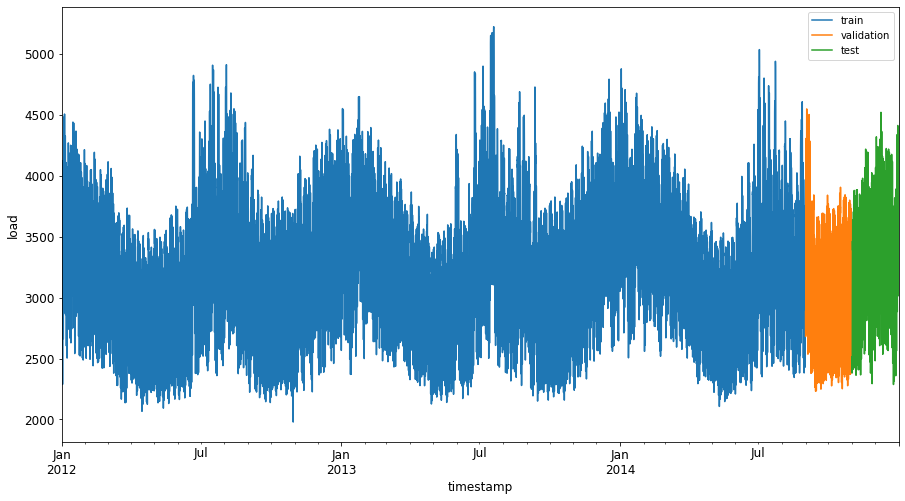

In [39]:
ts_data_load[ts_data_load.index < valid_st_data_load][["load"]].rename(columns={"load": "train"}).join(
    ts_data_load[(ts_data_load.index >= valid_st_data_load) & (ts_data_load.index < test_st_data_load)][
        ["load"]
    ].rename(columns={"load": "validation"}),
    how="outer",
).join(
    ts_data_load[test_st_data_load:][["load"]].rename(columns={"load": "test"}), how="outer"
).plot(
    y=["train", "validation", "test"], figsize=(15, 8), fontsize=12
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

In [40]:
T = 6
HORIZON = 1
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load][["load"]]

scaler = MinMaxScaler()
train["load"] = scaler.fit_transform(train)

train_shifted = train.copy()
train_shifted["y_t+1"] = train_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    train_shifted[str(T - t)] = train_shifted["load"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
train_shifted.columns = ["load_original"] + [y_col] + X_cols

train_shifted = train_shifted.dropna(how="any")
train_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


In [41]:
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()

In [42]:
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [43]:
y_train.shape

(23370,)

In [44]:
y_train[:3]

array([0.18, 0.23, 0.29])

In [45]:
X_train.shape

(23370, 6, 1)

In [46]:
X_train[:3]

array([[[0.22],
        [0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15]],

       [[0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18]],

       [[0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23]]])

In [47]:
train_shifted.head(3)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23


In [48]:
look_back_dt = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    hours=T - 1
)
valid = ts_data_load.copy()[(ts_data_load.index >= look_back_dt) & (ts_data_load.index < test_st_data_load)][
    ["load"]
]

valid["load"] = scaler.transform(valid)

valid_shifted = valid.copy()
valid_shifted["y+1"] = valid_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    valid_shifted["load_t-" + str(T - t)] = valid_shifted["load"].shift(T - t, freq="H")

valid_shifted = valid_shifted.dropna(how="any")
valid_shifted.head(3)

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2014-09-01 00:00:00,0.28,0.24,0.61,0.58,0.51,0.43,0.34,0.28
2014-09-01 01:00:00,0.24,0.22,0.58,0.51,0.43,0.34,0.28,0.24
2014-09-01 02:00:00,0.22,0.22,0.51,0.43,0.34,0.28,0.24,0.22


In [51]:
y_valid = valid_shifted["y+1"].to_numpy()
X_valid = valid_shifted[["load_t-" + str(T - t) for t in range(1, T + 1)]].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [52]:
y_valid.shape

(1463,)

In [53]:
y_valid[:3]

array([0.24, 0.22, 0.22])

In [54]:
X_valid.shape

(1463, 6, 1)

In [55]:
X_valid[:3]

array([[[0.61],
        [0.58],
        [0.51],
        [0.43],
        [0.34],
        [0.28]],

       [[0.58],
        [0.51],
        [0.43],
        [0.34],
        [0.28],
        [0.24]],

       [[0.51],
        [0.43],
        [0.34],
        [0.28],
        [0.24],
        [0.22]]])

### Modeling

In [57]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = (
    10
)

In [58]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [59]:
model.compile(optimizer="RMSprop", loss="mse")

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 120       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [61]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [62]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/10
731/731 [==============================] - 15s 13ms/step - loss: 0.0021 - val_loss: 8.6866e-04A: 1s -  - ETA: 0s - loss: 
Epoch 2/10
731/731 [==============================] - 5s 7ms/step - loss: 6.8801e-04 - val_loss: 5.4943e-04
Epoch 3/10
731/731 [==============================] - 6s 8ms/step - loss: 5.9719e-04 - val_loss: 5.6179e-04
Epoch 4/10
731/731 [==============================] - 6s 8ms/step - loss: 5.7604e-04 - val_loss: 5.0745e-04
Epoch 5/10
731/731 [==============================] - 5s 7ms/step - loss: 5.6843e-04 - val_loss: 5.1360e-04
Epoch 6/10
731/731 [==============================] - 5s 7ms/step - loss: 5.6411e-04 - val_loss: 8.6491e-04
Epoch 7/10
731/731 [==============================] - 5s 7ms/step - loss: 5.5962e-04 - val_loss: 5.6613e-04TA: 2s - loss: 5.6238e-0 - ETA: 2s - loss: 5.6 - ETA: 1s - loss: 5.594 -
Epoch 8/10
731/731 [==============================] - 5s 7ms/step - loss: 5.5503e-04 - val_loss: 4.9386e-04
Epoch 9/10
731/731 [===================

In [64]:
look_back_dt = dt.datetime.strptime(test_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    hours=T - 1
)
test = ts_data_load.copy()[test_st_data_load:][["load"]]

test["load"] = scaler.transform(test)

test_shifted = test.copy()
test_shifted["y_t+1"] = test_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    test_shifted["load_t-" + str(T - t)] = test_shifted["load"].shift(T - t, freq="H")

test_shifted = test_shifted.dropna(how="any")

y_test = test_shifted["y_t+1"].to_numpy()
X_test = test_shifted[["load_t-" + str(T - t) for t in range(1, T + 1)]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], T, 1)

In [65]:
y_test.shape

(1458,)

In [66]:
X_test.shape

(1458, 6, 1)

In [67]:
ts_predictions = model.predict(X_test)
ts_predictions

array([[0.22],
       [0.3 ],
       [0.38],
       ...,
       [0.54],
       [0.47],
       [0.43]], dtype=float32)

In [68]:
ev_ts_data = pd.DataFrame(
    ts_predictions, columns=["t+" + str(t) for t in range(1, HORIZON + 1)]
)
ev_ts_data["timestamp"] = test_shifted.index
ev_ts_data = pd.melt(ev_ts_data, id_vars="timestamp", value_name="prediction", var_name="h")
ev_ts_data["actual"] = np.transpose(y_test).ravel()
ev_ts_data[["prediction", "actual"]] = scaler.inverse_transform(
    ev_ts_data[["prediction", "actual"]]
)
ev_ts_data.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,689.84","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,960.94","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,224.85","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,354.45","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,483.36","3,436.00"


### Model Evaluation

In [69]:
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((ts_predictions - actuals).abs() / actuals).mean()

In [70]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.016093864058080734

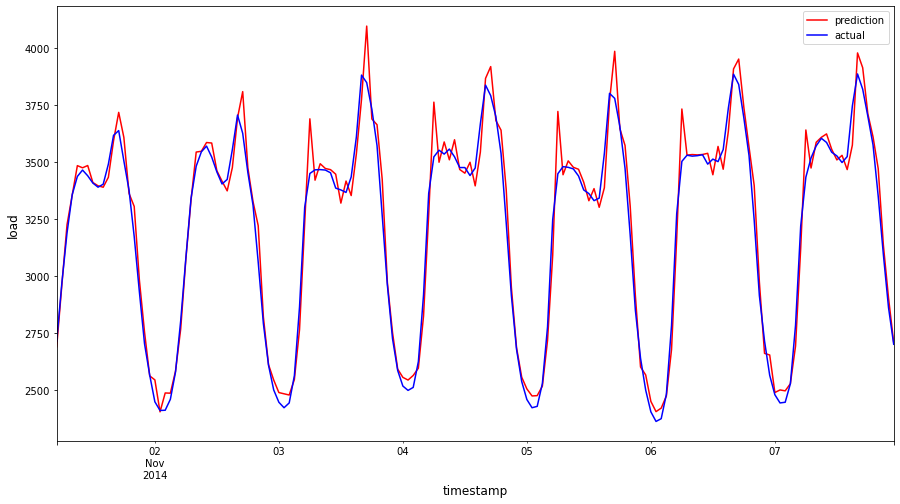

In [71]:
ev_ts_data[ev_ts_data.timestamp < "2014-11-08"].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(15, 8)
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

## Multivariate model

In [74]:
data_dir = "./data/"
ts_data = load_data(data_dir)
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [75]:
valid_st_data_load = "2014-09-01 00:00:00"
test_st_data_load = "2014-11-01 00:00:00"

In [76]:
T = 6
HORIZON = 1

In [81]:
y_scaler = MinMaxScaler()
y_scaler.fit(train[["load"]])

MinMaxScaler()

In [80]:
train = ts_data.copy()[ts_data.index < valid_st_data_load][["load", "temp"]]
X_scaler = MinMaxScaler()
train[["load", "temp"]] = X_scaler.fit_transform(train)

In [82]:
train.head()

,load,temp
2012-01-01 00:00:00,0.22,0.42
2012-01-01 01:00:00,0.18,0.43
2012-01-01 02:00:00,0.14,0.40
2012-01-01 03:00:00,0.13,0.41
2012-01-01 04:00:00,0.13,0.42


In [83]:
tensor_structure = {"X": (range(-T + 1, 1), ["load", "temp"])}
ts_train_inp = TimeSeriesTensor(
    dataset=train,
    target="load",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="H",
    drop_incomplete=True,
)
back_ts_data = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    hours=T - 1
)
valid = ts_data.copy()[(ts_data.index >= back_ts_data) & (ts_data.index < test_st_data_load)][
    ["load", "temp"]
]
valid[["load", "temp"]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, "load", HORIZON, tensor_structure)

### Modeling

In [84]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50

model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(Dense(HORIZON))

In [85]:
model.compile(optimizer="RMSprop", loss="mse")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 135       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [87]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [88]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_inputs["X"], valid_inputs["target"]),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/50
731/731 [==============================] - 15s 12ms/step - loss: 0.0257 - val_loss: 0.0021
Epoch 2/50
731/731 [==============================] - 6s 8ms/step - loss: 0.0014 - val_loss: 9.5986e-04
Epoch 3/50
731/731 [==============================] - 5s 7ms/step - loss: 8.7592e-04 - val_loss: 0.0012
Epoch 4/50
731/731 [==============================] - 6s 8ms/step - loss: 7.2317e-04 - val_loss: 8.4941e-04
Epoch 5/50
731/731 [==============================] - 5s 7ms/step - loss: 6.3268e-04 - val_loss: 5.0494e-04
Epoch 6/50
731/731 [==============================] - 5s 6ms/step - loss: 5.8497e-04 - val_loss: 5.7402e-04
Epoch 7/50
731/731 [==============================] - ETA: 0s - loss: 5.5824e-0 - 4s 6ms/step - loss: 5.5788e-04 - val_loss: 5.3081e-04
Epoch 8/50
731/731 [==============================] - 4s 6ms/step - loss: 5.4624e-04 - val_loss: 5.2085e-04
Epoch 9/50
731/731 [==============================] - 5s 6ms/step - loss: 5.4019e-04 - val_loss: 5.1661e-04
Epoch 10/50
73

In [94]:
back_ts_data = dt.datetime.strptime(test_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    hours=T - 1
)
ts_data_test = ts_data.copy()[test_st_data_load:][["load", "temp"]]
ts_data_test[["load", "temp"]] = X_scaler.transform(ts_data_test)
ts_data_test_inputs = TimeSeriesTensor(ts_data_test, "load", HORIZON, tensor_structure)

ts_predictions = model.predict(ts_data_test_inputs["X"])

ev_ts_data = create_evaluation_df(ts_predictions, ts_data_test_inputs, HORIZON, y_scaler)
ev_ts_data.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,0.23,0.23
1,2014-11-01 06:00:00,t+1,0.30,0.31
2,2014-11-01 07:00:00,t+1,0.39,0.37
3,2014-11-01 08:00:00,t+1,0.43,0.42
4,2014-11-01 09:00:00,t+1,0.47,0.45


### Model Evaluation

In [95]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.0523874743090587